In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

## Get a first glimpse of the data

In [2]:
# read the data set
df_calendar = pd.read_csv('./AirBnB_Seattle/calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
# read the data set
df_listings = pd.read_csv('./AirBnB_Seattle/listings.csv')
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
# read the data set
df_reviews = pd.read_csv('./AirBnB_Seattle/reviews.csv')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


## Data cleaning

In [5]:
# remove rows with no price info
df_calendar = df_calendar.dropna(subset=['price'],axis=0)
# remove reviews with no comments
df_reviews = df_reviews.dropna(subset=['comments'],axis=0)

In [6]:
df_calendar['price']=df_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
df_calendar['date']=pd.to_datetime(df_calendar['date'])
df_calendar['dayofweek']=df_calendar['date'].dt.dayofweek
df_calendar['month']=df_calendar.date.dt.month
df_calendar['year']=df_calendar.date.dt.year
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 934542 entries, 0 to 1393213
Data columns (total 7 columns):
listing_id    934542 non-null int64
date          934542 non-null datetime64[ns]
available     934542 non-null object
price         934542 non-null float64
dayofweek     934542 non-null int64
month         934542 non-null int64
year          934542 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 57.0+ MB


In [7]:
# df_listings[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']].head()
# df_listings=df_listings.dropna(subset=['review_scores_rating'], axis=0)

In [8]:
df_listings=df_listings.rename(columns={'id':'listing_id'})

df_listings['monthly_price'] = pd.to_numeric(df_listings['monthly_price'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
df_listings['price'] = pd.to_numeric(df_listings['price'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
df_listings['weekly_price'] = pd.to_numeric(df_listings['weekly_price'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
df_listings['security_deposit'] = pd.to_numeric(df_listings['security_deposit'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
df_listings['cleaning_fee'] = pd.to_numeric(df_listings['cleaning_fee'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
df_listings['extra_people'] = pd.to_numeric(df_listings['extra_people'].apply(lambda x: str(x).replace('$', '').replace(',', '')),errors='coerce')
df_listings['host_response_rate'] = pd.to_numeric(df_listings['host_response_rate'].apply(lambda x: str(x).replace('%', ''))
                                        ,errors='coerce')
df_listings['host_since']=pd.to_datetime(df_listings['host_since'])
df_listings['month']=df_listings.host_since.dt.month
df_listings['year']=df_listings.host_since.dt.year

# df_listings.info()

In [9]:
# merge data
df_calendar_listing=df_listings.merge(df_calendar,on='listing_id')

## Deal with some categorical data in the listing

In [10]:
#Create dummy columns for all the categorical variables in df_listings, drop the original columns
cat_vars = list(['host_acceptance_rate', 'host_is_superhost', 'host_verifications',\
                 'cancellation_policy','smart_location'])

# cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in cat_vars:
    df_listings = pd.concat([df_listings.drop(var, axis=1), pd.get_dummies(df_listings[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    

## Analyze the price differences by the day of the week, and the date/month of the year

In [11]:
price_by_date=df_calendar.groupby('date')[['price']].mean()

(array([16804, 16832, 16861, 16892, 16922, 16953, 16983, 17014, 17045,
        17075, 17106, 17136, 17167, 17168]),
 <a list of 14 Text xticklabel objects>)

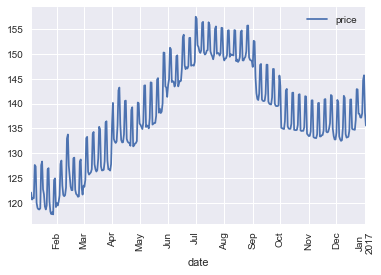

In [12]:
price_by_date.plot()
plt.xticks(rotation=90)

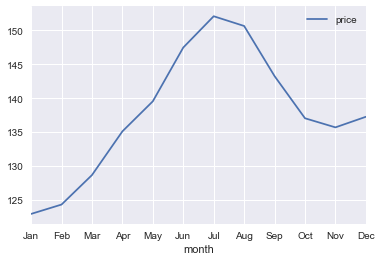

In [13]:
price_by_month=df_calendar.groupby('month')[['price']].mean()
price_by_month.plot()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.savefig("price_month.png", bbox_inches = 'tight')

In [14]:
price_by_weekday=df_calendar.groupby('dayofweek')[['price']].mean()

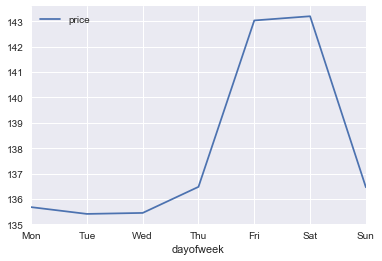

In [15]:
price_by_weekday.plot()
plt.xticks(range(0,7),['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.savefig("price_dayofweek.png", bbox_inches = 'tight')

## Listing information

(array([  1.33900000e+03,   1.60000000e+03,   4.52000000e+02,
          2.18000000e+02,   7.50000000e+01,   7.20000000e+01,
          2.40000000e+01,   1.20000000e+01,   1.20000000e+01,
          1.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   4.00000000e+00]),
 array([   20.        ,    85.33333333,   150.66666667,   216.        ,
          281.33333333,   346.66666667,   412.        ,   477.33333333,
          542.66666667,   608.        ,   673.33333333,   738.66666667,
          804.        ,   869.33333333,   934.66666667,  1000.        ]),
 <a list of 15 Patch objects>)

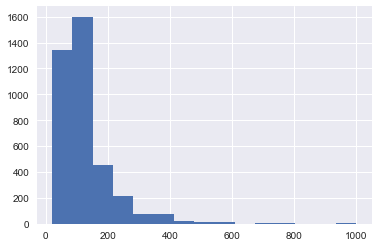

In [16]:
plt.hist(df_listings['price'],bins=15)

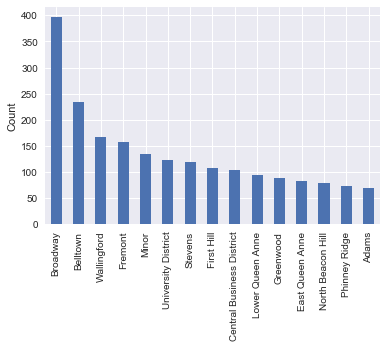

In [17]:
df_listings['neighbourhood_cleansed'].value_counts().head(15).plot(kind='bar')
plt.ylabel("Count")
plt.savefig("neighbourhood_count.png", bbox_inches = 'tight')

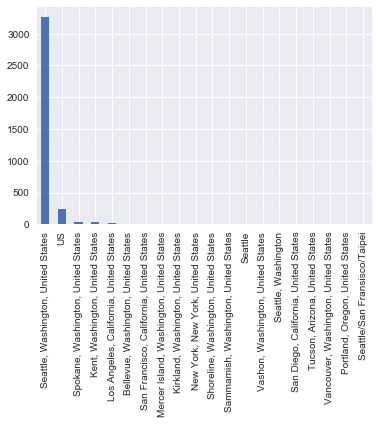

In [18]:
df_listings['host_location'].value_counts().head(20).plot(kind='bar')

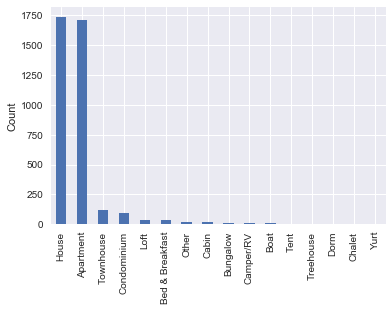

In [19]:
df_listings['property_type'].value_counts().head(20).plot(kind='bar')
plt.ylabel("Count")
plt.savefig("property_type_count.png", bbox_inches = 'tight')

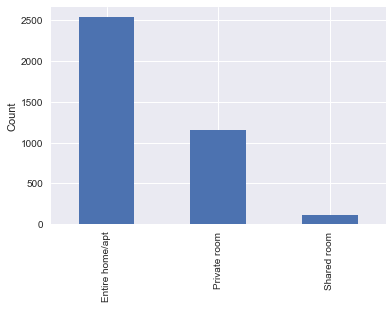

In [20]:
df_listings['room_type'].value_counts().head(20).plot(kind='bar')
plt.ylabel("Count")
plt.savefig("room_type_count.png", bbox_inches = 'tight')

([<matplotlib.axis.XTick at 0x11b015630>,
 <a list of 12 Text xticklabel objects>)

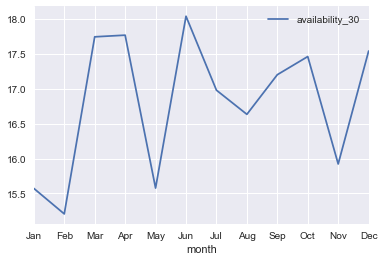

In [21]:
avail_30=df_listings.groupby('month')[['availability_30']].mean()
avail_30.plot()
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

## What affects the review score

In [22]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 214 entries, listing_id to smart_location_西雅图, WA
dtypes: datetime64[ns](1), float64(26), int64(13), object(49), uint8(125)
memory usage: 3.0+ MB


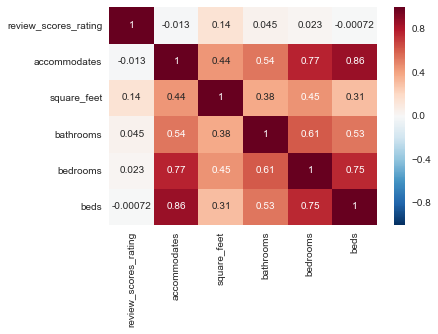

In [23]:
sns.heatmap(
    df_listings[[
        'review_scores_rating',\
        'property_type', 'accommodates',\
        'amenities', 'square_feet',\
        'bathrooms', 'bedrooms', 'beds',\
                 ]].corr(),annot=True
)

plt.savefig("review_room.png", bbox_inches = 'tight')

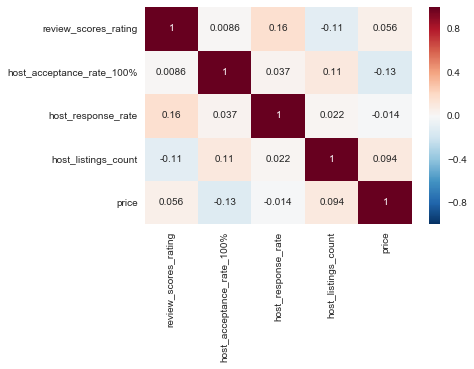

In [32]:
sns.heatmap(
    df_listings[[
        'review_scores_rating', 'host_acceptance_rate_100%',\
        'host_response_time', 'host_response_rate',\
        'host_listings_count', 'price'\
                 ]].corr(),annot=True
)

plt.savefig("review_host.png", bbox_inches = 'tight')

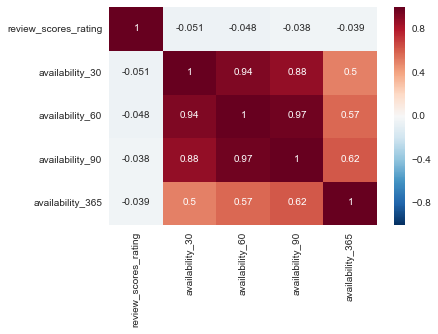

In [25]:
sns.heatmap(
    df_listings[[
        'review_scores_rating', \
        'availability_30', 'availability_60',\
        'availability_90', 'availability_365',\
                 ]].corr(),annot=True
)

plt.savefig("review_availability.png", bbox_inches = 'tight')

In [27]:
# list(df_listings)

['listing_id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'guests_included',
 'ext

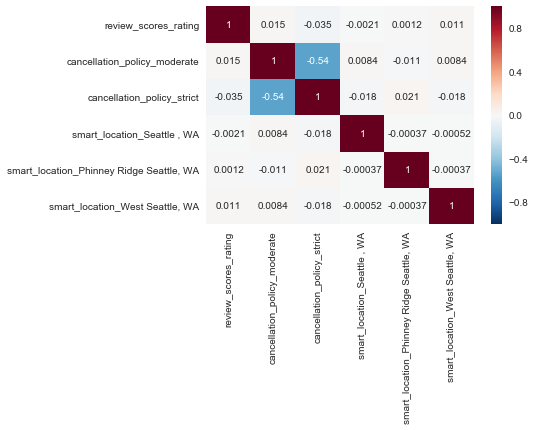

In [31]:
sns.heatmap(
    df_listings[[
        'review_scores_rating',\
        'cancellation_policy_moderate', 'cancellation_policy_strict',\
        'smart_location_Seattle , WA', 'smart_location_Phinney Ridge Seattle, WA',\
        'smart_location_West Seattle, WA',\
                 ]].corr(),annot=True
)

plt.savefig("review_cancellation_smart_loc.png", bbox_inches = 'tight')